<a href="https://colab.research.google.com/github/CamelGoong/DataScienceLab/blob/main/%5B%EB%B0%95%ED%95%B4%EA%B7%A0%5D210819_CNN_%EC%84%B8%EC%85%98%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torch.nn as nn #많은 neural network이 담겨있는 모듈입니다. 
import torch.optim as optim  # 많은 optimizer가 담겨있는 모듈입니다. 
import torch.nn.init as init # neural network를 초기화 하는 모듈을 담고 있습니다. 
from torch.utils.data import DataLoader # DataLoader는 데이터를 batch_size만큼 불러오는 역할 등을 수행합니다. 
import torchvision 
import torchvision.datasets as dset # 사진 등의 vision 데이터가 담겨있는 모듈입니다. 
import torchvision.transforms as transforms #이 모듈에는 데이터를 자르고, 반전시키고 tensor로 변환해주기 등의 데이터 변환 함수가 담겨있습니다.
import numpy as np
import os 
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
print(torch.__version__)


1.9.0+cu102


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip -qq "/content/gdrive/MyDrive/DSL/20210819_CNN/archive.zip" -d "/content/gdrive/MyDrive/DSL/20210819_CNN/"

In [4]:
path = '/content/gdrive/MyDrive/DSL/20210819_CNN/chest_xray'
mean = torch.tensor([0.4822])
std = torch.tensor([0.2328])
transformations = transforms.Compose([transforms.Resize((64,64)), 
                              transforms.ToTensor(), 
                              transforms.Normalize(mean, std),
                             ])

In [5]:
train = ImageFolder(os.path.join(path, 'train'), transform=transformations, target_transform=lambda x:np.reshape(np.float32(x),(1)))
val = ImageFolder(os.path.join(path, 'val'), transform=transformations, target_transform=lambda x:np.reshape(np.float32(x),(1)))
test = ImageFolder(os.path.join(path, 'test'), transform=transformations)

In [6]:
print(train.__getitem__(0)[0].size(), train.__len__())
print(test.__getitem__(0)[0].size(), test.__len__())

print(len(train),len(test))
#print(mnist_train[0])


torch.Size([3, 64, 64]) 5216
torch.Size([3, 64, 64]) 624
5216 624


In [7]:
num_epoch=10
batch_size=100
learning_rate= 0.001

In [8]:
#데이터 쪼개기
train_loader=DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=DataLoader(dataset=test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(                                 # input_size = [batch_size, 3, 64, 64] # 컬러 이미지니까
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3), # [batch_size, 16, 62, 62]  
            nn.ReLU(),                                                         
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3), # [batch_size, 32, 60, 60]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),     # [batch_size, 32, 30, 30]
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3), # [batch_size, 32, 28, 28]
            nn.ReLU(),                      
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # [batch_size, 64, 26, 26]         
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # [batch_size, 64, 13, 13]   
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=5), # [batch_size, 64, 9, 9]  
            nn.ReLU(),                                                         
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=5), # [batch_size, 64, 5, 5]
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3), # [batch_size, 64, 3, 3]
            nn.ReLU(),
                                      
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*3*3,100),                                             
            nn.ReLU(),
            nn.Linear(100,2)                                                  
        )       
        
    def forward(self,x):
        out = self.layer(x)                                                     
        out = out.view(out.shape[0],-1)                                       
                                                                                
                                                                                
        out = self.fc_layer(out)
        return out

In [10]:
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')  

print(device)

model=CNN().to(device)

loss_func = nn.CrossEntropyLoss().to(device)

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

cuda:0


In [11]:
loss_arr=[]
for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):
    x=image.to(device)            
    y_=label.to(device, dtype=torch.int64)           
    output=model.forward(x)
    # loss = loss_func(output, y_)     
    loss = loss_func(output, torch.max(y_, 1)[1])
    loss.backward()
    optimizer.step()    
    
    if j%1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)


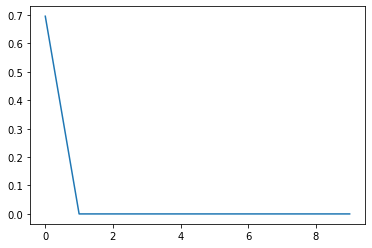

In [12]:
plt.plot(loss_arr)
plt.show()

In [13]:
correct=0
total=0

with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)
    output=model.forward(x)
     #https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
    _,output_index=torch.max(output,1)  #max함수는 max value와 max value의 index를 도출합니다. 두 번째 인자 1은 결과의 dimension을 의미합니다. 

    total+=label.size(0)

    correct += (output_index==y_).sum().float()

print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 39.0%
